In [166]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as st
import math


<h2> Here we are getting the data organized based on a specified starting year </h2>

In [167]:
#THIS IS THE YEAR WE WANT TO START AND FINISH CALCULATING THE AVERAGE FROM
#min year is 1980 because the stats are pretty sketchy prior

start_year = 2020
end_year = 2020

In [168]:
all_players_df = pd.read_csv("csv_files/player_stats_"+str(start_year)+".csv")
all_players_df = all_players_df.drop_duplicates('NAME', keep='first')
all_players_df['YEAR']= start_year

for year in range(start_year+1, end_year+1):
    
    #store current year in df
    current_year_players_df = pd.read_csv("csv_files/player_stats_"+str(year)+".csv")

    #since some players were traded during each season their stats are split first showing TOT (total season)
    #and the following rows showing their stats specific for their teams
    #since the total is always first we can drop all duplicates following the first instance (ASSUMING NO PLAYERS HAVE THE SAME NAME)
    current_year_players_df = current_year_players_df.drop_duplicates('NAME', keep='first')
    current_year_players_df['YEAR'] = year
    #appending the current year to all previous years 
    all_players_df = all_players_df.append(current_year_players_df, ignore_index=True)
    
    


In [194]:
#HERE WE WILL SET CRITERIA FOR OUR DATA BASE AND GET RID OF NANs

#filling null values with 0
players_df = all_players_df.fillna(0)

#Need to reset index cause when a player has played  on multiple teams 
#then they show up multiple times and we only want season total
players_df = players_df.reset_index()




<h2> Adding true shooting percentage to our dataframe </h2> 

In [170]:
#Helper methods that take in the original data frame and output each stat 
def add_true_shooting(df):
    list_of_TS = []
    #goes through each row of the df and uses data to calculate each stat
    for index, player in df.iterrows():
        #this if statement prevents a divide by zero exception
        if(player['FGA']==0):
            list_of_TS.append(0.00000)
            continue
        ts = player['PTS']/(2*(player['FGA']+(0.44*player['FTA'])))
        #appends this calculated stat to the list 
        list_of_TS.append(ts)
    #adds list to dataframe with proper header    
    df['TS'] = list_of_TS
    return df


In [218]:
player_std = []

#going through every player tows
for index, player in players_df.iterrows():
    
    ###### UNCOMMENT IF WE WANT A CERTAIN PPG ######
#     if player['PTS'] < 10:
#         continue
    
    
    #storing average ppg and average min in variables to make more readabble
    avg_ppg = player['PTS']
    avg_min = player['MP']
    gp = player['G']
    
    #names with III and Jr. don't connect to our game log datasets so we must fix the strings
    name = player['NAME'].replace(" III","").replace(" Jr.","").replace(" ","_")
    
    #just gonna hardcode the messed up names
    if name == 'Mo_Bamba':
        name = 'Mohamed_Bamba'
    elif name == 'Gary_Payton_II':
        name = 'Gary_Payton'
    elif name == 'Taurean_Prince':
        name = 'Taurean_Waller-Prince'
     
    #Keeping this in a try catch block just in case in the future we want to edit it for multiple seasons
    try:
        game_log_df = pd.read_csv("csv_files/"+ name +"_game_log_2020.csv")
    except:
        print(name + " this file does not exist")
        continue
 
    #Here we are measuring the standard deviation of a player 
    #the player must've played over one game for the calculation to work 
    if player['G'] > 1:
        std_pts = st.stdev(game_log_df['PTS'],avg_ppg)
        
    else: 
        continue
      
    
   

    #here we are getting min played 
    min_played = []
    for game_min in game_log_df['MP']:

        #turning MP into floats of min and seconds
        game_min = game_min.replace(":",".")
        min_and_sec = float(game_min)

        #converting to just units of minutes
        min_val = math.floor(min_and_sec)
        sec_val = min_and_sec % 1
        sec_val = sec_val / 0.6
        sec_val = round(sec_val,2)

        #appending the total min to list
        min_played.append(min_val + sec_val)
        
    std_min = st.stdev(min_played,avg_min)
    
    
    
    
    player_std.append([name,std_pts,std_min,avg_ppg,gp])
    
    
    


<h2> Predicting STD </h2>
<p> Here we are going to compute the predicted standard deviation in points scored relative to the number of points score and plot this prediction <p> 

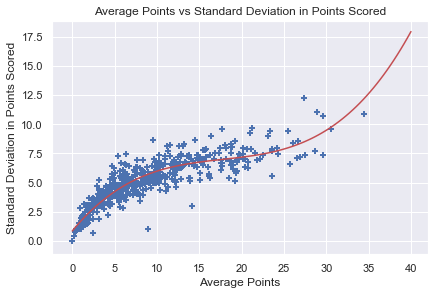

In [175]:
import numpy as np
from numpy.linalg import inv
import pylab

x = []
y = []

for player in player_std:
     
    x.append(player[3])
    y.append(player[1])
    
# making the arrays numpy 
x = np.array(x)
y = np.array(y)

#setting the highest degree of the vandermonde matrix
N = 4

#setting Matrix 
X = np.vander(x, 4, increasing=True)

#Our regression model will look like y = c0 + c1*x1 + c2*x2^2 + c3*x3^3
#To get these values of c we use: c = (X^T*X)^-1*X^T*y

XT = X.transpose()

#c = (X^T*X)^-1*X^T*y
c = np.matmul(inv(np.matmul(XT,X)),np.matmul(XT,y))


#this is the polynomial of our prediction curve 
def prediction(x):
   
    return c[0] + c[1]*x + c[2]*(x**2) + c[3]*(x**3)

#This is graphing our prediction curve 
pylab.title("Average Points vs Standard Deviation in Points Scored")
pylab.xlabel("Average Points")
pylab.ylabel("Standard Deviation in Points Scored")
x_graph = np.linspace(0,40,100)
y_graph = prediction(x_graph)
pylab.plot(x_graph,y_graph,'r') 

#this is plotting our scatter plot of points vs std
pylab.scatter(x,y,marker="+" )

pylab.show()






<h2> Computing Residual values </h2>

In [223]:
residual_values = []

#going through all players
for player in player_std:
    
    #getting data from player 
    name = player[0]
    std_points = player[1]
    std_min = player[2]
    avg_pts = player[3]
    gp = player[4]
    
    #computing the residual value 
    residual = std_points - prediction(avg_pts)
    
    residual_values.append([name, residual,std_min, avg_pts,gp])


residual_values.sort(key=lambda x:x[1], reverse = True)




In [224]:
residual_values

[['Kyrie_Irving', 3.7784009004214045, 4.672006528248864, 27.4, 20],
 ['Garrison_Mathews', 2.8256917575010405, 7.632374650818546, 5.4, 18],
 ['Shake_Milton', 2.7599902788152146, 11.362317105238702, 9.5, 32],
 ['C.J._Miles', 2.593730017945024, 5.414998614958272, 6.4, 10],
 ['Caris_LeVert', 2.569967239542943, 6.154152356585769, 17.7, 39],
 ['Naz_Mitrou-Long', 2.3597430910103494, 11.486439831383787, 4.7, 3],
 ['Kemba_Walker', 2.347740674547385, 5.353242526826186, 21.2, 50],
 ['Dwayne_Bacon', 2.110987880645533, 8.937059787862106, 5.7, 39],
 ['Norman_Powell', 2.0854040968771805, 7.349669751393287, 16.4, 44],
 ['Damian_Lillard', 2.0655574164933217, 3.761713788037242, 28.9, 58],
 ['Chris_Clemons', 2.044369654083301, 8.055187815247777, 4.9, 29],
 ['Admiral_Schofield', 2.0404014745317443, 9.261233803708421, 3.1, 27],
 ['Paul_George', 1.963056772667156, 6.185420289515974, 21.0, 42],
 ['Eric_Gordon', 1.9570371332077023, 5.67185609083583, 14.5, 34],
 ['Jordan_McRae', 1.9019254175889877, 9.429920330

In [230]:
df = pd.DataFrame(residual_values,columns=["Name", "Inconsistency", "STD Minutes", "AVG Points", "Games Played"])
df

,Name,Inconsistency,STD Minutes,AVG Points,Games Played
0,Kyrie_Irving,3.778401,4.672007,27.4,20
1,Garrison_Mathews,2.825692,7.632375,5.4,18
2,Shake_Milton,2.759990,11.362317,9.5,32
3,C.J._Miles,2.593730,5.414999,6.4,10
4,Caris_LeVert,2.569967,6.154152,17.7,39
...,...,...,...,...,...
503,Danilo_Gallinari,-1.993603,2.817508,19.2,55
504,Zion_Williamson,-2.034839,4.317601,23.6,19
505,Ryan_Anderson,-2.067626,4.030509,2.5,2
506,Marvin_Bagley,-3.693196,5.051487,14.2,13


<h2> Analyzing data </h2>

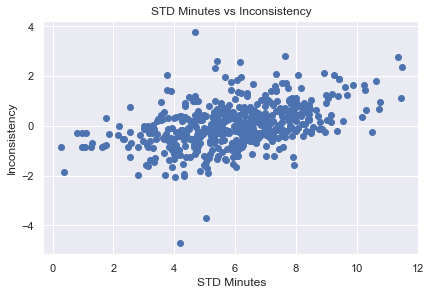

In [215]:
pylab.title("STD Minutes vs Inconsistency")
pylab.xlabel("STD Minutes")
pylab.ylabel("Inconsistency")

pylab.scatter( df['STD Minutes'],df['Inconsistency'])



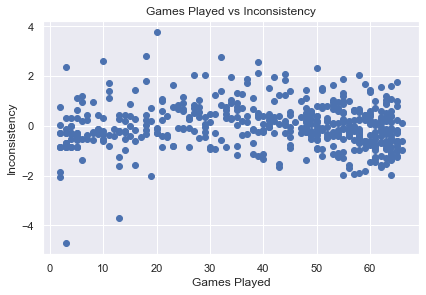

In [229]:
pylab.title("Games Played vs Inconsistency")
pylab.xlabel("Games Played")
pylab.ylabel("Inconsistency")

pylab.scatter( df['Games Played'],df['Inconsistency'])

<h2> Code to look at players scoring distrobution </h2> 

[]

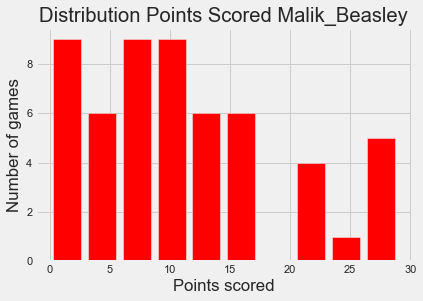

In [173]:
name = "Malik_Beasley"
game_log_df = pd.read_csv("csv_files/"+ name +"_game_log_2020.csv")


plt.style.use('fivethirtyeight')

#making the plot 
pts_dist, g = plt.subplots()

g.hist(game_log_df['PTS'],color='red',bins=10,rwidth=0.8)
g.set_xlabel("Points scored")
g.set_ylabel("Number of games")
g.set_title("Distribution Points Scored " + name)
g.plot()